In [1]:
import os
import torch
import json
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, pipeline
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    TextDataset,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)
import matplotlib.pyplot as plt
# Set GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

2025-04-09 16:51:58.848244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744217518.870302 2165589 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744217518.877044 2165589 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-09 16:51:58.900626: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


device(type='cuda')

In [2]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [3]:
# Load train, dev, and test data
train_data = load_data('./dataset/train.json')
dev_data = load_data('./dataset/dev.json')
test_data = load_data('./dataset/test.json')

In [4]:
# Check the keys of the train_data dictionary
print(train_data.keys())  # Check the keys in the dictionary
print(dev_data.keys())    # Check the keys in the dev_data dictionary
print(test_data.keys())   # Check the keys in the test_data dictionary

dict_keys(['documents', 'labels'])
dict_keys(['documents', 'labels'])
dict_keys(['documents', 'labels'])


In [5]:
def extract_text(data, key='documents'):
    # Extract the 'text' field from each dictionary in the list under the 'documents' key
    return [entry['text'] for entry in data[key]]  # Ensure 'text' is the correct field name

In [6]:
train_texts = extract_text(train_data, key='documents')
dev_texts = extract_text(dev_data, key='documents')
test_texts = extract_text(test_data, key='documents')

# Print the first 5 texts to verify
print(train_texts[:1])

["NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\nThis NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT (“Agreement”) is made by and between:\n(i) the Office of the United Nations High Commissioner for Refugees, having its headquarters located at 94 rue de Montbrillant, 1202 Geneva, Switzerland (hereinafter “UNHCR” or the “Discloser”); and\n(ii) ________________________ , a company established in accordance with the laws of ________________________ and having its principal offices located at ________________________________________________ (hereinafter the “Bidder” or the “Recipient”).\nThe Discloser and Recipient are also referred to collectively as the “Parties” and individually as a “Party”.\nRECITALS\nWHEREAS in connection with RFP/2014/620, Request for Proposal for the provision Off-the-shelf Soft-skill, IT Online and HR specific E-learning Courses (the “RFP”), it is advantageous to share certain data and information with the Bidder participating in the RFP;\nWHEREAS UNHCR agrees to pro

In [7]:
# Count number of samples
num_train = len(train_texts)
num_dev = len(dev_texts)
num_test = len(test_texts)

# Function to calculate average word length
def avg_word_len(texts):
    return sum(len(text.split()) for text in texts) / len(texts)

avg_train_words = avg_word_len(train_texts)
avg_dev_words = avg_word_len(dev_texts)
avg_test_words = avg_word_len(test_texts)

# Optional: label distribution in training set
from collections import Counter
train_label_dist = Counter(train_data["labels"])
dev_label_dist = Counter(dev_data["labels"])
test_label_dist = Counter(test_data["labels"])

# Print results
print("Number of samples:")
print(f"Train: {num_train}, Dev: {num_dev}, Test: {num_test}\n")

print("Average word count per document:")
print(f"Train: {avg_train_words:.2f}, Dev: {avg_dev_words:.2f}, Test: {avg_test_words:.2f}\n")

print("Label distribution in training set:")
print(train_label_dist)


Number of samples:
Train: 423, Dev: 61, Test: 123

Average word count per document:
Train: 1673.63, Dev: 1823.84, Test: 1708.82

Label distribution in training set:
Counter({'nda-11': {'short_description': 'No reverse engineering', 'hypothesis': "Receiving Party shall not reverse engineer any objects which embody Disclosing Party's Confidential Information."}, 'nda-16': {'short_description': 'Return of confidential information', 'hypothesis': 'Receiving Party shall destroy or return some Confidential Information upon the termination of Agreement.'}, 'nda-15': {'short_description': 'No licensing', 'hypothesis': 'Agreement shall not grant Receiving Party any right to Confidential Information.'}, 'nda-10': {'short_description': 'Confidentiality of Agreement', 'hypothesis': 'Receiving Party shall not disclose the fact that Agreement was agreed or negotiated.'}, 'nda-2': {'short_description': 'None-inclusion of non-technical information', 'hypothesis': 'Confidential Information shall only i

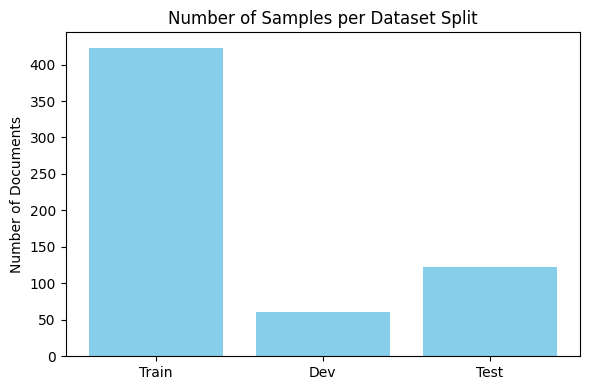

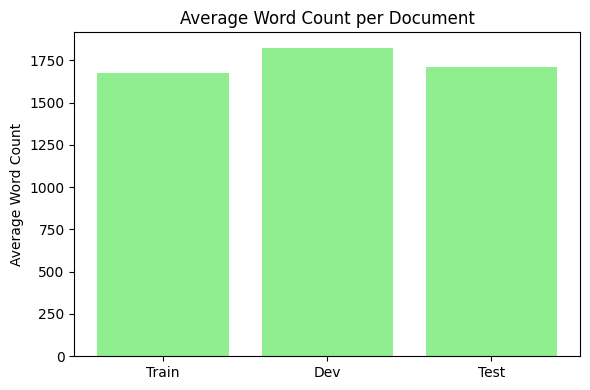

In [9]:
# Plot 1: Number of Samples
plt.figure(figsize=(6, 4))
plt.bar(['Train', 'Dev', 'Test'], [num_train, num_dev, num_test], color='skyblue')
plt.title("Number of Samples per Dataset Split")
plt.ylabel("Number of Documents")
plt.tight_layout()
plt.show()

# Plot 2: Average Word Count
plt.figure(figsize=(6, 4))
plt.bar(['Train', 'Dev', 'Test'], [avg_train_words, avg_dev_words, avg_test_words], color='lightgreen')
plt.title("Average Word Count per Document")
plt.ylabel("Average Word Count")
plt.tight_layout()
plt.show()

In [ ]:
with open("dataset/legal_docs.txt", "w", encoding="utf-8") as f:
    for doc in train_texts:
        doc = doc.replace("\n", " ").strip()  # Optional: flatten formatting
        f.write(doc + "\n\n")  # Separate docs with double line breaks

In [31]:
with open("dataset/legal_eval.txt", "w", encoding="utf-8") as f:
    for doc in dev_texts:
        doc = doc.replace("\n", " ").strip()
        f.write(doc + "\n\n")

In [22]:
output_path = "dataset/legal_docs.txt"

with open(output_path, "r", encoding="utf-8") as f:
    preview = f.read().split("\n\n")[:4]
    for i, doc in enumerate(preview, 1):
        print(f"\n--- Document {i} ---\n{doc[:500]}...\n")


--- Document 1 ---
NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT This NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT (“Agreement”) is made by and between: (i) the Office of the United Nations High Commissioner for Refugees, having its headquarters located at 94 rue de Montbrillant, 1202 Geneva, Switzerland (hereinafter “UNHCR” or the “Discloser”); and (ii) ________________________ , a company established in accordance with the laws of ________________________ and having its principal offices located at ______________...


--- Document 2 ---
NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIPATION Table of Content 1 Eligibility ..........................................................................................................................................2 2 Procedure and terms of participation ...............................................................................................3 3 Payment ......................................................................................

In [23]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

Embedding(50257, 768)

In [24]:
def load_dataset(file_path, tokenizer, block_size=512):
    return TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=block_size
    )

train_dataset = load_dataset("dataset/legal_docs.txt", tokenizer)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

/home/jupyter-st124738/.local/lib/python3.12/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [25]:
training_args = TrainingArguments(
    output_dir="./gpt2_legal_model",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    save_steps=500,
    save_total_limit=2,
    logging_steps=100,
    prediction_loss_only=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: st124738 (st124738-asian-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,2.553900
200,2.385300
300,2.316900
400,2.270300
500,2.187900
600,2.199600
700,2.161800
800,2.160900
900,2.109800
1000,1.984900


TrainOutput(global_step=2706, training_loss=2.016021010264237, metrics={'train_runtime': 371.6418, 'train_samples_per_second': 14.554, 'train_steps_per_second': 7.281, 'total_flos': 1413328601088000.0, 'train_loss': 2.016021010264237, 'epoch': 3.0})

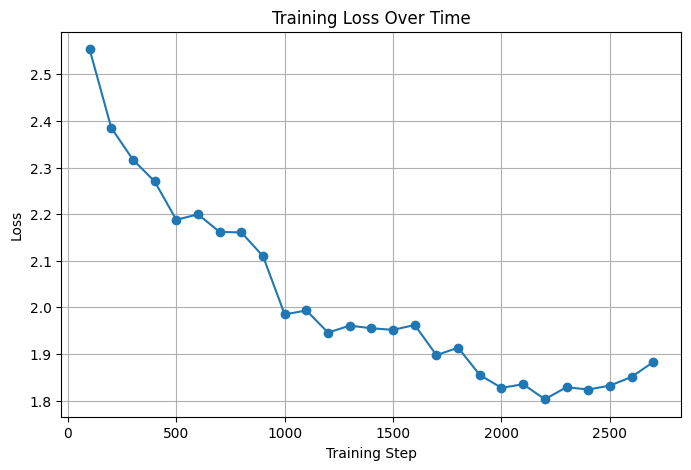

In [26]:
import matplotlib.pyplot as plt

# Extract loss from trainer logs
log_history = trainer.state.log_history
loss_values = [entry["loss"] for entry in log_history if "loss" in entry]
steps = [entry["step"] for entry in log_history if "loss" in entry]

# Plot the loss
plt.figure(figsize=(8, 5))
plt.plot(steps, loss_values, marker='o')
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.show()


In [32]:
from transformers import TextDataset

eval_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="dataset/legal_eval.txt",
    block_size=512
)

/home/jupyter-st124738/.local/lib/python3.12/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [33]:
eval_results = trainer.evaluate(eval_dataset=eval_dataset)
print(eval_results)

{'eval_loss': 1.957987904548645, 'eval_runtime': 4.2266, 'eval_samples_per_second': 66.721, 'eval_steps_per_second': 8.518, 'epoch': 3.0}


In [34]:
import math
perplexity = math.exp(eval_results["eval_loss"])
print(f"Perplexity: {perplexity:.2f}")

Perplexity: 7.09


In [27]:
trainer.save_model("./gpt2_legal_model")
tokenizer.save_pretrained("./gpt2_legal_model")

('./gpt2_legal_model/tokenizer_config.json',
 './gpt2_legal_model/special_tokens_map.json',
 './gpt2_legal_model/vocab.json',
 './gpt2_legal_model/merges.txt',
 './gpt2_legal_model/added_tokens.json')

In [38]:
#inference
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model = GPT2LMHeadModel.from_pretrained("./gpt2_legal_model")
tokenizer = GPT2Tokenizer.from_pretrained("./gpt2_legal_model")

prompt = "THIS AGREEMENT is "
input_ids = tokenizer(prompt, return_tensors="pt").input_ids

output = model.generate(
    input_ids,
    max_length=300,
    temperature=0.8,
    top_p=0.95,
    top_k=50,
    do_sample=True,
    num_return_sequences=1
)

generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated:\n", generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated:
 THIS AGREEMENT is _________, and is entered into this ____________, ____________, by and between _________________________________, _________________________________, and ______________________________________________________________________, each of which is a party hereto and each of which is a party hereto. NOW, THEREFORE, in consideration of the covenants and agreements contained herein, the parties hereto agree as follows: 1. Purpose. The term “Party” means any individual, corporation, association, limited liability company, partnership, limited liability company, other legal entity, partnership, government agency, trust, corporation, trust, corporation, government agency, trust, partnership, other legal entity, partnership, government agency, trust, corporation, trust, corporation, government agency, trust, partnership, other legal entity, partnership, government agency, trust, partnership, other legal entity, partnership, government agency, trust, partnership, other 

In [39]:
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def extract_text(data, key='documents'):
    return [entry.get('text', '') for entry in data.get(key, [])]

reference_data = load_data("dataset/dev.json")
reference_texts = extract_text(reference_data)

In [40]:
from bert_score import score

# Make sure both lists are same length (for demo, let's use 1-to-1)
candidates = [generated_text]  # from generation
references = [reference_texts[0]]  # pick a similar-length target reference

P, R, F1 = score(candidates, references, lang="en", verbose=True)

print(f"\n🔍 BERTScore:")
print(f"Precision: {P.mean().item():.4f}")
print(f"Recall:    {R.mean().item():.4f}")
print(f"F1 Score:  {F1.mean().item():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.02 sentences/sec

🔍 BERTScore:
Precision: 0.7456
Recall:    0.7663
F1 Score:  0.7558
